# Fly Scans with EPICS motor and scaler

The `ScalerMotorFlyer()` device from [apstools](https://bcda-aps.github.io/apstools/api/_devices.html#apstools.devices.flyer_motor_scaler.ScalerMotorFlyer) makes it possible to run fly scans with just the EPICS motor and scaler records.

This combination of positioner and detector represent common EPICS support available to most APS beam lines.  An external fly scan controller is not necessary, nor is any dedicated data collection hardware.  Keep in mind that the capabilities of the motor and scaler will provide certain limits on how fast the scan completes and how many data points may be collected.

**Contents**

- [What is a bluesky/ophyd 'Flyer'?](#Overview)
- [Step-by-step outline of 'ScalerMotorFlyer()'](#Outline)
- [Prepare the session](#Setup)
- [Run the fly scan](#Scan)
- [Get the data and plot it](#Visualize)

## Overview

Q: *What is a bluesky/ophyd `Flyer`?*

A bluesky/ophyd
[Flyer](https://github.com/bluesky/ophyd/blob/0e8acb3df3d17e0ab7aa2cc924831f4a0c580449/ophyd/flyers.py#L17) is an ophyd [Device](https://github.com/bluesky/ophyd/blob/0e8acb3df3d17e0ab7aa2cc924831f4a0c580449/ophyd/device.py#L778) which describes a data collection process that is not managed by the bluesky RunEngine.
Examples of such data collection processes include:

- A system using dedicated hardware to control the measurement sequence and collect data.
- Some software that can be called from Python.
- A Python function that runs in a background thread.

The `Flyer` interfaces with the RunEngine with these three distinct steps:

1. `kickoff()` : Start the fly scan.
2. `complete()` : Wait for the fly scan to complete.
3. `collect()` : Get (and report) the fly scan data.

Note: There is an additional step, `describe_collect()`, which informs bluesky
about the type(s) of data reported by `collect()`.

In `ScalerMotorFlyer()`, the *fly scan* protocol is managed by the
`actions_thread()` method.  This method is run in its own thread so it does not
interfere with the bluesky `RunEngine`.

## Outline

Here is a step-by-step outline of the fly scan protocol:

1. Setup
   1. Scaler update rate is set from the requested sampling `period`.
2. Taxi
   1. Motor is sent to the `start` position (using original velocity).
   2. Wait for motor to reach `start` position.
3. Fly
   1. Motor velocity is set based on the requested `start` & `finish` positions and `fly_time` for the scan.
   2. Scaler count time set to `fly_time` plus a smidgen (`scaler_time_pad`).
   3. Start periodic data collection
      1. Scaler provides (EPICS Channel Access) updates as new data is available.
      2. Record motor position & scaler channel counts.
      3. Record time stamps for motor and scaler (probably different).
      4. Data accumulated to internal memory.
   4. Scaler is started to count.
   5. Motor is sent to `finish` (using fly scan velocity).
   6. Wait for motor to stop moving.
   7. Scaler is stopped.
   8. Stop periodic data collection
4. Finish
   1. Reset to previous values
      1. motor velocity
      2. scaler update rate
   2. Report any acquired data to Bluesky RunEngine.
      1. Data for each counter is reported as the difference of successive readings.

If any exceptions are raised by steps 1-3 (such as cannot set a value, timeout, wrong type of parameter given, ...), skip directly to step 4.

## Setup

Without [more explanation here](https://bcda-aps.github.io/apstools/examples/de_0_adsim_hdf5_basic.html#bluesky), we set up our bluesky session for data acquisition, importing needed libraries and constructing the RunEngine and databroker for a temporary catalog.  We will use an [EPICS IOC](https://hub.docker.com/r/prjemian/custom-synapps-6.2/tags) with the prefix `gp:`.  This IOC provides a simulated motor and a simulated scaler, among other [features](https://github.com/prjemian/epics-docker/tree/main/v1.1/n5_custom_synApps#readmemd).  The scaler is preconfigured with detector inputs.  When the scaler is counting, its counters (detector channels) are updated by random integers.

In [1]:
%matplotlib inline
from apstools.devices import ScalerMotorFlyer
from bluesky import RunEngine
from bluesky import plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback
from matplotlib import pyplot as plt
from ophyd import EpicsMotor
from ophyd.scaler import ScalerCH
import databroker

IOC = "gp:"

# ophyd-level
m1 = EpicsMotor(f"{IOC}m10", name="motor")
scaler = ScalerCH(f"{IOC}scaler1", name="scaler")
m1.wait_for_connection()
scaler.wait_for_connection()
scaler.select_channels()

# bluesky-level
cat = databroker.temp().v2
plt.ion()  # enables matplotlib graphics
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
best_effort_callback = BestEffortCallback()
RE.subscribe(best_effort_callback)  # LivePlot & LiveTable

1

Create the `flyer` object that will be used by the bluesky [fly()](https://blueskyproject.io/bluesky/generated/bluesky.plans.fly.html#bluesky.plans.fly) plan.  The `ScalerMotorFlyer()` deivce supports the ophyd flyer interface, as described above.

In this example, we describe a fly scan from motor position 1 to 5 that should take 4 seconds, collecting data at 0.1 second intervals.  Other keyword parameters are accepted.  See the documentation for full details.

In [2]:
flyer = ScalerMotorFlyer(scaler, m1, 1, 5, fly_time=4, period=.1, name="flyer")

## Scan

Using our `flyer` device with the bluesky [fly()](https://blueskyproject.io/bluesky/generated/bluesky.plans.fly.html#bluesky.plans.fly) plan, run the fly scan.  Supply additional metadata so we can label our plot.  The call to `RE()` returns a list of the uids for each run that was executed.  Collect this list (we expect only one uid int he list) for later use when accessing the run from the databroker.

In [3]:
uids = RE(bp.fly([flyer], md=dict(title="Demonstrate a scaler v. motor fly scan.")))



Transient Scan ID: 1     Time: 2022-10-19 12:26:01
Persistent Unique Scan ID: '2ea02bd5-fa7b-489b-b5b1-4d4ce68d353c'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+


/home/prjemian/.conda/envs/bluesky_2022_3/lib/python3.9/site-packages/event_model/__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


+-----------+------------+
generator fly ['2ea02bd5'] (scan num: 1)





Note that the LiveTable and LivePlot from the BestEffortCallback do not yet know how to show this data, so they report minimal information about the fly scan.

## Visualize

To make a plot of the data, first get the run from the databroker, identified here by its uid.

In [4]:
run = cat.v2[uids[0]]
run

BlueskyRun
  uid='2ea02bd5-fa7b-489b-b5b1-4d4ce68d353c'
  exit_status='success'
  2022-10-19 12:26:01.178 -- 2022-10-19 12:26:09.829
  Streams:
    * primary


Show some of the run's metadata, verifying that we are looking at the run we just acquired.

In [5]:
print(f"{run.metadata['start']['scan_id']=}")
print(f"{run.metadata['start']['title']=}")

run.metadata['start']['scan_id']=1
run.metadata['start']['title']='Demonstrate a scaler v. motor fly scan.'


The `run` has a single stream of data, named `primary`.  Get the data from that stream:

In [6]:
dataset = run.primary.read()
dataset

<xarray.Dataset>
Dimensions:              (time: 43)
Coordinates:
  * time                 (time) float64 1.666e+09 1.666e+09 ... 1.666e+09
Data variables:
    motor                (time) float64 1.0 1.09 1.09 1.19 ... 4.9 4.9 4.97 5.0
    motor_user_setpoint  (time) float64 1.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    timebase             (time) float64 -1e+06 1e+06 1e+06 ... 1e+06 1e+06 1e+06
    I0                   (time) float64 0.0 0.0 1.0 0.0 1.0 ... 1.0 1.0 0.0 0.0
    scint                (time) float64 0.0 0.0 0.0 1.0 0.0 ... 0.0 1.0 1.0 0.0
    diode                (time) float64 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 1.0
    I000                 (time) float64 0.0 0.0 1.0 0.0 1.0 ... 0.0 1.0 0.0 0.0
    I00                  (time) float64 0.0 0.0 0.0 1.0 1.0 ... 0.0 1.0 0.0 0.0
    scaler_time          (time) float64 -0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1

Choose data for the x and y axes from the `dataset` names:

In [7]:
x = dataset["motor"]
y = dataset["diode"]

Plot the data using matplotlib's [pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) module.  (The `pyplot as plt` library was imported above.)

Text(0, 0.5, 'diode')

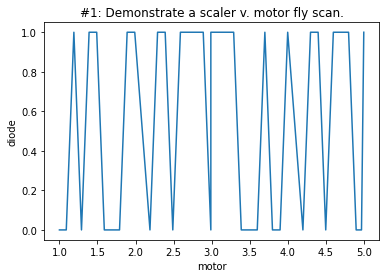

In [8]:
title = (
    f"#{run.metadata['start']['scan_id']}"
    f": {run.metadata['start']['title']}"
)
plt.plot(x.values, y.values)
plt.title(title)
plt.xlabel(x.name)
plt.ylabel(y.name)